In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
import pyodbc
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()

In [2]:
# Load data
price_data = pd.read_csv('price_data.csv')
price_data_500 = price_data.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))

theme_df = pd.read_excel('SectorMapping.xlsx')
theme_df = theme_df[['Symbol', 'Theme']]  # Ensure only relevant columns are kept

df = price_data_500[['Date', 'Symbol', 'Close', 'Mcap','Volume']].merge(theme_df, on='Symbol', how='inner')
df['Theme'] = df['Theme'].fillna('Others')
df.set_index('Date', inplace=True)

# Define periods for momentum ratios (in trading days)
periods = {
    'MR0.5': 10,  # Half-month
    'MR1': 21,    # 1 month
    'MR2': 42,    # 2 months
    'MR3': 63,    # 3 months
    'MR6': 126,   # 6 months
    'MR9': 189,   # 9 months
    'MR12': 252,  # 12 months
    'MR18': 378,  # 18 months
    'MR24': 504   # 24 months
}

# Function to calculate log returns
def calculate_log_returns(df):
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    return df.dropna()

# Function to calculate annualized standard deviation
def calculate_annualized_std(df, window=252):
    return df['LogReturn'].rolling(window).std() * np.sqrt(window)

# Function to calculate momentum ratios
def calculate_momentum_ratios(series, period):
    return series / series.shift(period) - 1

# Apply log return calculation
df = df.groupby('Symbol', group_keys=False).apply(calculate_log_returns)

# Calculate momentum ratios for each period
for label, period in periods.items():
    df[label] = df.groupby('Symbol')['Close'].transform(lambda x: calculate_momentum_ratios(x, period))

# Approach 1: Momentum-only by returns
# Calculate the mean and std deviation of each momentum ratio across the universe
for label in periods.keys():
    df[f'mu_{label}'] = df.groupby('Date')[label].transform(lambda x: x.mean())
    df[f'sigma_{label}'] = df.groupby('Date')[label].transform(lambda x: x.std())

# Calculate Z-scores for each period
for label in periods.keys():
    df[f'Z_{label}'] = (df[label] - df[f'mu_{label}']) / df[f'sigma_{label}']

# Specific combinations for normalized momentum score (momentum-only by returns)
specific_combinations = [('MR6', 'MR12')]

for comb in specific_combinations:
    comb_labels = [f'Z_{label}' for label in comb]
    comb_weights = np.ones(len(comb_labels)) / len(comb_labels)  # Equal weights
    comb_name = "_".join(comb)
    
    # Weighted average Z-score
    df[f'WeightedAvgZ_Returns_{comb_name}'] = df[comb_labels].dot(comb_weights)
    
    # Normalized momentum score
    df[f'NormalizedMomentumScore_Returns_{comb_name}'] = np.where(
        df[f'WeightedAvgZ_Returns_{comb_name}'] >= 0,
        1 + df[f'WeightedAvgZ_Returns_{comb_name}'],
        (1 - df[f'WeightedAvgZ_Returns_{comb_name}']) ** -1
    )

# Approach 2: Momentum normalized by returns/volatility
# Calculate annualized standard deviation
df['AnnualizedStd'] = df.groupby('Symbol', group_keys=False).apply(calculate_annualized_std)

# Normalize momentum ratios by dividing by the annualized standard deviation
for label in periods.keys():
    df[label] /= df['AnnualizedStd']

# Recalculate Z-scores for volatility-normalized momentum ratios
for label in periods.keys():
    df[f'mu_{label}_vol'] = df.groupby('Date')[label].transform(lambda x: x.mean())
    df[f'sigma_{label}_vol'] = df.groupby('Date')[label].transform(lambda x: x.std())
    df[f'Z_{label}_vol'] = (df[label] - df[f'mu_{label}_vol']) / df[f'sigma_{label}_vol']

# Specific combinations for normalized momentum score (returns/volatility)
for comb in specific_combinations:
    comb_labels_vol = [f'Z_{label}_vol' for label in comb]
    comb_name_vol = "_".join(comb)
    
    # Weighted average Z-score
    df[f'WeightedAvgZ_ReturnsVol_{comb_name_vol}'] = df[comb_labels_vol].dot(comb_weights)
    
    # Normalized momentum score
    df[f'NormalizedMomentumScore_ReturnsVol_{comb_name_vol}'] = np.where(
        df[f'WeightedAvgZ_ReturnsVol_{comb_name_vol}'] >= 0,
        1 + df[f'WeightedAvgZ_ReturnsVol_{comb_name_vol}'],
        (1 - df[f'WeightedAvgZ_ReturnsVol_{comb_name_vol}']) ** -1
    )

# Final selection: Keep only top 500 by Mcap per date
df = df.groupby('Date', group_keys=False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))

# Clean up intermediate columns if needed
drop_cols = [f'mu_{label}' for label in periods.keys()] + [f'sigma_{label}' for label in periods.keys()]
drop_cols += [f'mu_{label}_vol' for label in periods.keys()] + [f'sigma_{label}_vol' for label in periods.keys()]
df = df.drop(columns=drop_cols, errors='ignore')

# Save or inspect the final DataFrame
df.reset_index(inplace=True)
df

,Date,Symbol,Close,Mcap,Volume,Theme,LogReturn,MR0.5,MR1,MR2,...,Z_MR1_vol,Z_MR2_vol,Z_MR3_vol,Z_MR6_vol,Z_MR9_vol,Z_MR12_vol,Z_MR18_vol,Z_MR24_vol,WeightedAvgZ_ReturnsVol_MR6_MR12,NormalizedMomentumScore_ReturnsVol_MR6_MR12
0,1994-11-08,RELIANCE,19.932822,139882.412340,49050.0,Refineries,0.001263,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-11-08,TATASTEEL,17.854114,107525.559102,7200.0,Steel & Iron Products,0.001574,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-11-08,DRREDDY,21.550000,11302.619856,6100.0,Pharmaceuticals & Drugs,0.011669,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-11-10,RELIANCE,19.152623,134407.216907,67250.0,Refineries,-0.039928,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-11-10,TATASTEEL,16.871576,101608.272045,132500.0,Steel & Iron Products,-0.056604,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620955,2025-01-17,SIGNATURE,1128.550000,158573.340328,570010.0,Construction - Real Estate,-0.004950,-0.481281,-0.320942,-0.314438,...,-0.838273,-0.840537,-0.924928,-0.256557,-0.306593,-0.245975,NaN,NaN,-0.251266,0.799191
2620956,2025-01-17,ASAHIINDIA,649.950000,157996.300653,42991.0,Glass,-0.015647,-0.318218,-0.387381,-0.068255,...,-1.177894,-0.185590,-0.334422,-0.097824,0.002682,-0.119395,-0.307122,-0.579554,-0.108609,0.902031
2620957,2025-01-17,GRAVITA,2130.500000,157248.904856,132559.0,Metal - Non Ferrous,-0.026768,-0.016038,-0.041226,4.241244,...,0.591574,11.279446,9.448603,1.552777,1.177806,1.049212,NaN,NaN,1.300995,2.300995
2620958,2025-01-17,FINCABLES,1028.100000,157236.940594,553173.0,Cable,-0.002817,-0.254769,-0.357034,-0.192189,...,-1.022767,-0.515305,-0.702986,-0.344217,-0.150134,-0.261658,-0.492897,-0.131498,-0.302937,0.767497


In [3]:
df = df[['Date', 'Symbol', 'Close', 'Mcap','Volume','NormalizedMomentumScore_Returns_MR6_MR12','NormalizedMomentumScore_ReturnsVol_MR6_MR12']]

# Step 1: Calculate Turnover
df['Turnover'] = df['Volume'] * df['Close']

# Group by Symbol and calculate EMAs
def calculate_ema(group):
    group['20EMA_Turnover'] = group['Turnover'].ewm(span=20, adjust=False).mean()
    group['100EMA_Turnover'] = group['Turnover'].ewm(span=100, adjust=False).mean()
    group['Turnover_EMA_Ratio'] = group['20EMA_Turnover'] / group['100EMA_Turnover']
    return group

df = df.groupby('Symbol').apply(calculate_ema)

# Step 1: Recalculate Z-scores for Turnover EMA Ratio across dates
df['mu_Turnover_EMA_Ratio_vol'] = df.groupby('Date')['Turnover_EMA_Ratio'].transform(lambda x: x.mean())
df['sigma_Turnover_EMA_Ratio_vol'] = df.groupby('Date')['Turnover_EMA_Ratio'].transform(lambda x: x.std())
df['Z_Turnover_EMA_Ratio_vol'] = (df['Turnover_EMA_Ratio'] - df['mu_Turnover_EMA_Ratio_vol']) / df['sigma_Turnover_EMA_Ratio_vol']

# Step 2: Calculate Normalized Momentum Score for Turnover EMA Ratio
df['Turnover_Mom_Zscore'] = np.where(
    df['Z_Turnover_EMA_Ratio_vol'] >= 0,
    1 + df['Z_Turnover_EMA_Ratio_vol'],
    (1 - df['Z_Turnover_EMA_Ratio_vol']) ** -1
)

# Verify the final DataFrame with key columns

# Save or inspect the final DataFrame
df.reset_index(inplace=True)
df =  df[['Date', 'Symbol', 'Close', 'Mcap','Volume','NormalizedMomentumScore_Returns_MR6_MR12','NormalizedMomentumScore_ReturnsVol_MR6_MR12','Turnover_Mom_Zscore']]
df['Composite_Mom_Zscore'] = (df['NormalizedMomentumScore_Returns_MR6_MR12']*.40) + (df['NormalizedMomentumScore_ReturnsVol_MR6_MR12']*0.30) + (df['Turnover_Mom_Zscore']*0.30)

In [27]:
x = df[['Date','Symbol','Composite_Mom_Zscore']].dropna()
x = x.sort_values(by=['Date','Composite_Mom_Zscore'], ascending=[True,False])
x
# top_25_stocks_each_day = x.groupby('Date').head(25)
# price_data['Date'] = pd.to_datetime(price_data['Date'])
# top_25_stocks_each_day['Date'] = pd.to_datetime(top_25_stocks_each_day['Date'])
# rebalanceFrequency=2
# from rebalancedate import *
# op=rebalancedates(price_data,'2006-06-02',17, rebalanceFrequency)
# rebalanceDates=op[1]
# df_rebalance_dates = pd.DataFrame({'Date': pd.to_datetime(rebalanceDates)})
# df_rebalance_dates
# top_25_stocks_each_day = top_25_stocks_each_day[top_25_stocks_each_day['Date'].isin(df_rebalance_dates['Date'])].reset_index(drop=True)
# top_25_stocks_each_day

,Date,Symbol,Composite_Mom_Zscore
1907,1995-11-29,TATASTEEL,1.997571
1906,1995-11-29,RELIANCE,1.214374
1917,1995-11-30,TATASTEEL,2.041866
1916,1995-11-30,RELIANCE,1.277186
1927,1995-12-01,TATASTEEL,1.976524
...,...,...,...
2620846,2025-01-17,STARHEALTH,0.723740
2620853,2025-01-17,SUNTV,0.720155
2620916,2025-01-17,KANSAINER,0.717757
2620911,2025-01-17,GRINDWELL,0.705184


In [ ]:
x['PercentileRank'] = x.groupby('Date')['Composite_Mom_Zscore'].rank(pct=True)

# Choose a few sample stocks for plotting
sample_stocks = ['KALYANKJIL', 'RELIANCE', 'ANANTRAJ', 'SRF', 'BIOCON']

# Filter the data for the sample stocks
sample_data = x[x['Symbol'].isin(sample_stocks)]

# Create a plot with subplots
fig, axes = plt.subplots(len(sample_stocks), 2, figsize=(12, len(sample_stocks) * 4))

# Loop through each sample stock and plot its data
for i, stock in enumerate(sample_stocks):
    stock_data = sample_data[sample_data['Symbol'] == stock]
    
    # Plot the Composite_Mom_Zscore
    axes[i, 0].plot(stock_data['Date'], stock_data['Composite_Mom_Zscore'], label='Z-score', color='b')
    axes[i, 0].set_title(f'{stock} - Z-score')
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('Composite Mom Z-score')
    axes[i, 0].grid(True)
    
    # Plot the Percentile Rank
    axes[i, 1].plot(stock_data['Date'], stock_data['PercentileRank'], label='Percentile Rank', color='r')
    axes[i, 1].set_title(f'{stock} - Percentile Rank')
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Percentile Rank')
    axes[i, 1].grid(True)

# Show the plot
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

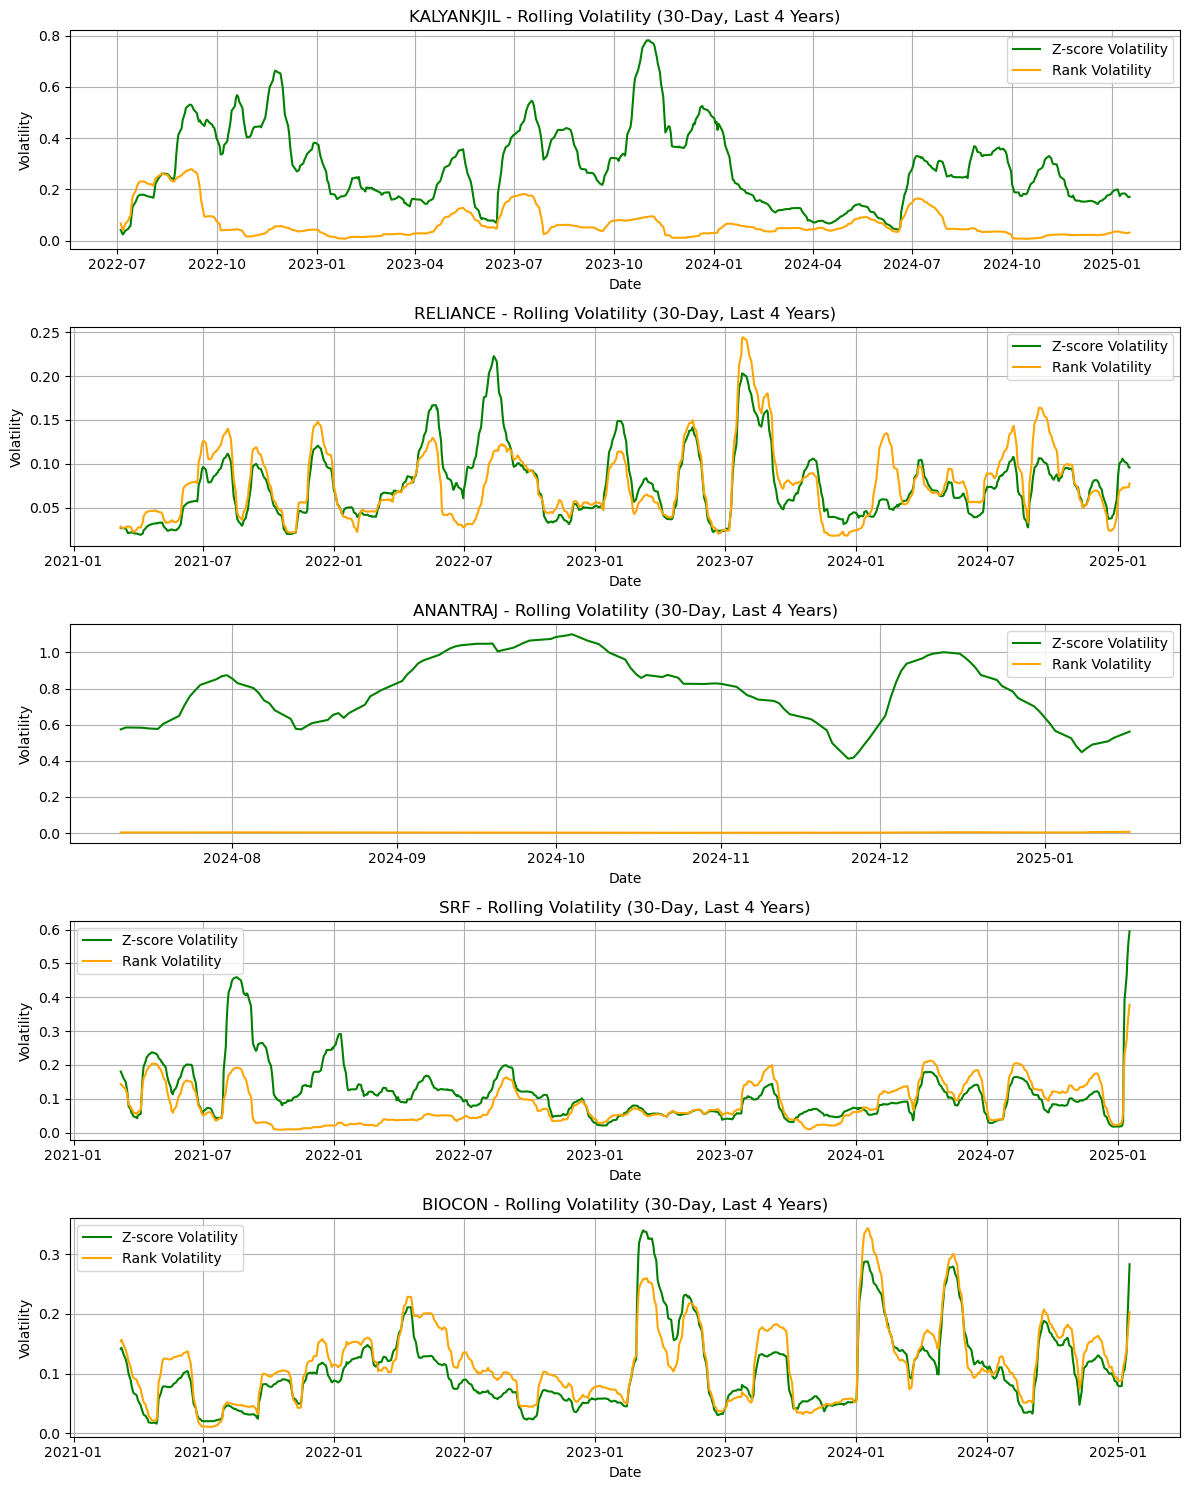

In [36]:
import datetime as dt

# Filter the data for the last 4 years
four_years_ago = dt.datetime.now() - dt.timedelta(days=4 * 365)
sample_data['Date'] = pd.to_datetime(sample_data['Date'])
filtered_data = sample_data[sample_data['Date'] >= four_years_ago]
# Rolling volatility (standard deviation) over a 30-day window
filtered_data['Zscore_Volatility'] = filtered_data.groupby('Symbol')['Composite_Mom_Zscore'].transform(lambda x: x.rolling(30).std())
filtered_data['Rank_Volatility'] = filtered_data.groupby('Symbol')['PercentileRank'].transform(lambda x: x.rolling(30).std())

# Plot for each stock in the sample
fig, axes = plt.subplots(len(sample_stocks), 1, figsize=(12, len(sample_stocks) * 3))

for i, stock in enumerate(sample_stocks):
    stock_data = filtered_data[filtered_data['Symbol'] == stock]
    axes[i].plot(stock_data['Date'], stock_data['Zscore_Volatility'], label='Z-score Volatility', color='green')
    axes[i].plot(stock_data['Date'], stock_data['Rank_Volatility'], label='Rank Volatility', color='orange')
    axes[i].set_title(f'{stock} - Rolling Volatility (30-Day, Last 4 Years)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

            PearsonCorr  SpearmanCorr
Symbol                               
ANANTRAJ       0.806910      0.862408
BIOCON         0.974753      0.976758
KALYANKJIL     0.784347      0.962658
RELIANCE       0.970721      0.982420
SRF            0.913790      0.992587


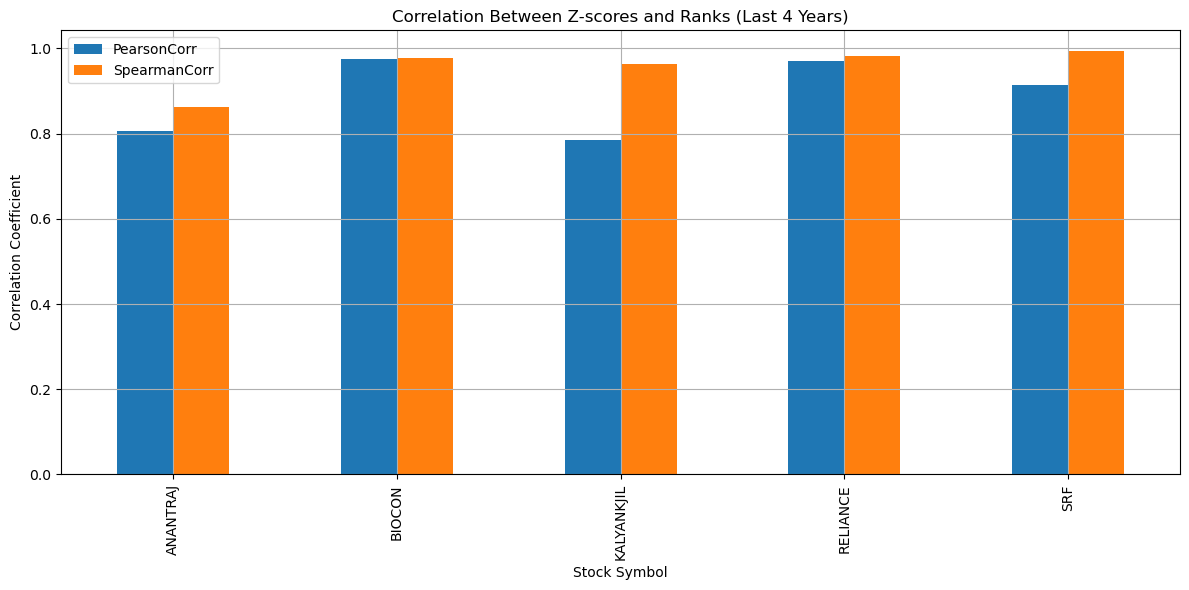

In [37]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Filter data for the last 4 years
last_4_years = sample_data[sample_data['Date'] >= pd.Timestamp.now() - pd.DateOffset(years=4)]

# Calculate correlations for all sample stocks
correlation_results = last_4_years.groupby('Symbol').apply(
    lambda x: pd.Series({
        'PearsonCorr': pearsonr(x['Composite_Mom_Zscore'], x['PercentileRank'])[0],
        'SpearmanCorr': spearmanr(x['Composite_Mom_Zscore'], x['PercentileRank'])[0]
    })
)

# Print correlation results
print(correlation_results)

# Plot correlations
correlation_results.plot(kind='bar', figsize=(12, 6), title='Correlation Between Z-scores and Ranks (Last 4 Years)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Stock Symbol')
plt.grid(True)
plt.tight_layout()
plt.show()
